#  Importing the required packages

In [83]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import lightgbm as lgb
import matplotlib.pyplot as ply
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error # 0.3 error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
#from chart_studio import chart_studio_plotly
#from plotly.plotly import iplot
import plotly.graph_objs as go
#import plotly.plotly as py
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
#init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

from plotly import tools
from plotly.subplots import make_subplots
import os
import sys
import math

# Data Reading

In [84]:
psdata=pd.read_csv('googleplaystore.csv')

In [85]:
psdata.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Data Preprocessing

# Handling NULL Values-Improves the accuracy of insights and predictions

In [86]:
print(psdata.isnull().sum())

psdata.dropna(inplace=True) #Dropping Rows with Null values

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


# There are many NULL values in Rating, and few in Type,Content Rating and Versions.

In [87]:
psdata1 = psdata.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

In [88]:
#val_model_fit=smf.ols("Installs ~ App+Category+Rating+Size+Type+Price+Content_Rating+Genres+Current_Ver+Android_Ver", data).fit()
#val_model_fit.summary()  

# Data Exploration

In [89]:
psdata1.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

# Data Cleaning

In [90]:
psdata1['Size'] = psdata1['Size'].astype('str') 

In [91]:
# Data cleaning for "Size" column
psdata1['Size'] = psdata1['Size'].map(lambda x: x.rstrip('M'))
psdata1['Size'] = psdata1['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
psdata1['Size'] = psdata1['Size'].map(lambda x: np.nan if x.startswith('Varies') else x)
psdata1.Size.head()


0     19
1     14
2    8.7
3     25
4    2.8
Name: Size, dtype: object

In [92]:
psdata1['Installs'] = psdata1['Installs'].map(lambda x: x.rstrip('+'))
psdata1['Installs'] = psdata1['Installs'].map(lambda x: ''.join(x.split(',')))
psdata1.Installs.head()

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: object

In [93]:
# Data cleaning for "Price" column
psdata1['Price'] = psdata1['Price'].map(lambda x: x.lstrip('$').rstrip())
psdata1.Price.head()

0    0
1    0
2    0
3    0
4    0
Name: Price, dtype: object

In [94]:
# Row [7312,8266] removed due to "Unrated" value in Content Rating
psdata1.drop(psdata1.index[[7312,8266]], inplace=True)

In [95]:
psdata1.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Feature Analysis

In [96]:
psdata1.Category.value_counts() #Displaying all the categories and their counts.

FAMILY                 1745
GAME                   1096
TOOLS                   733
PRODUCTIVITY            351
MEDICAL                 350
COMMUNICATION           328
FINANCE                 323
SPORTS                  319
PHOTOGRAPHY             317
LIFESTYLE               314
PERSONALIZATION         312
BUSINESS                303
HEALTH_AND_FITNESS      297
SOCIAL                  259
SHOPPING                238
NEWS_AND_MAGAZINES      233
TRAVEL_AND_LOCAL        226
DATING                  195
BOOKS_AND_REFERENCE     178
VIDEO_PLAYERS           160
EDUCATION               155
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     124
FOOD_AND_DRINK          109
HOUSE_AND_HOME           76
WEATHER                  75
AUTO_AND_VEHICLES        73
LIBRARIES_AND_DEMO       64
ART_AND_DESIGN           61
COMICS                   58
PARENTING                50
EVENTS                   45
BEAUTY                   42
Name: Category, dtype: int64

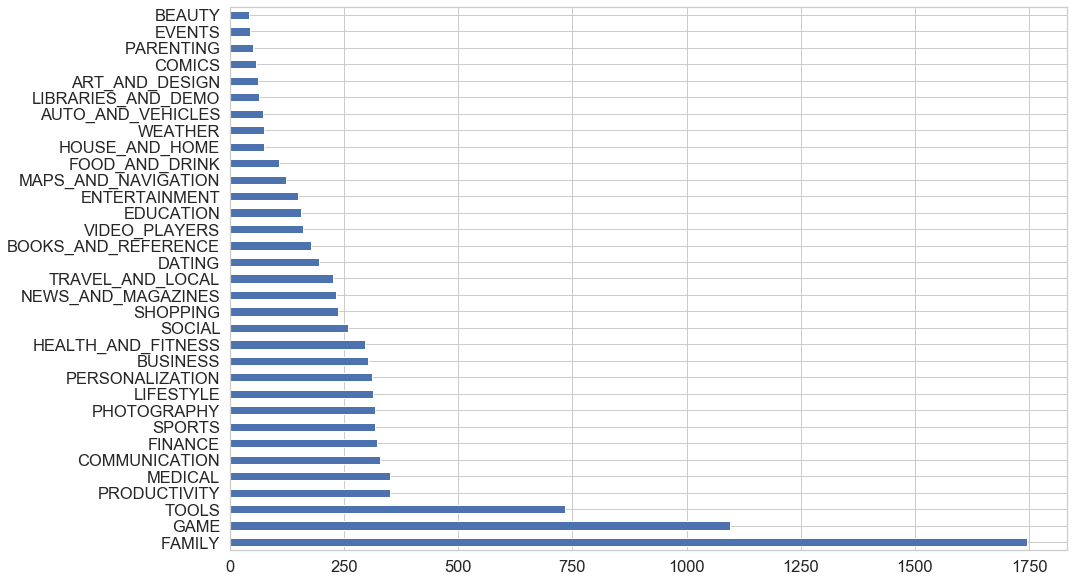

In [97]:
psdata1.Category.value_counts().plot(kind='barh',figsize= (15,10))

# Insight : Maximum Number of Apps belong to the Family and Game Category.


In [98]:
psdata.Rating.describe()

count    9360.000000
mean        4.191838
std         0.515263
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

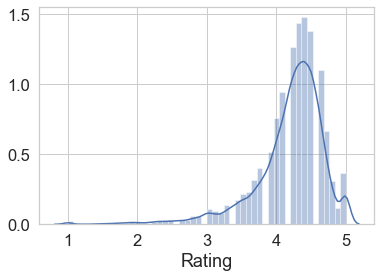

In [99]:
sns.distplot(psdata1.Rating)

#  Most of the apps, clearly hold a rating above 4.0. Lets check how many app have 5 rating.


In [100]:
print("Number of Apps with full ratings: ",psdata1.Rating[psdata1['Rating'] == 5 ].count())

Number of Apps with full ratings:  274


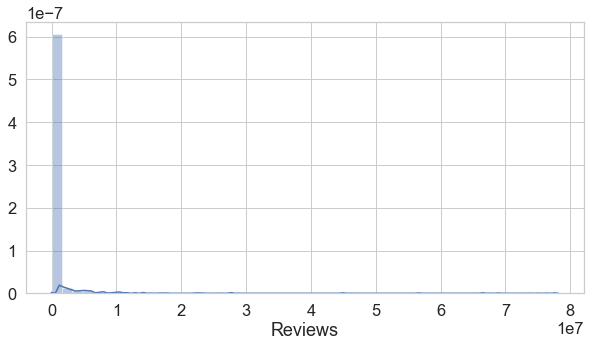

In [101]:
psdata1.Reviews = psdata1.Reviews.astype('int64') #Changing to int type.
plt.figure(figsize=(10,5))
sns.distplot(psdata1.Reviews)


# Let's look into those apps which have a good amount of Reviews,The most famous Apps like WhatsApp, Facebook and Clash of Clans are the most reviewed Apps as shown below.

In [102]:
psdata1[psdata1.Reviews>10000000]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,NaN,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
342,Viber Messenger,COMMUNICATION,4.3,11334799,NaN,500000000,Free,0,Everyone,Communication,"July 18, 2018",Varies with device,Varies with device
378,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,40,500000000,Free,0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up
381,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578,NaN,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
385,Viber Messenger,COMMUNICATION,4.3,11334973,NaN,500000000,Free,0,Everyone,Communication,"July 18, 2018",Varies with device,Varies with device
391,Skype - free IM & video calls,COMMUNICATION,4.1,10484169,NaN,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
403,LINE: Free Calls & Messages,COMMUNICATION,4.2,10790289,NaN,500000000,Free,0,Everyone,Communication,"July 26, 2018",Varies with device,Varies with device
406,BBM - Free Calls & Messages,COMMUNICATION,4.3,12842860,NaN,100000000,Free,0,Everyone,Communication,"August 2, 2018",Varies with device,4.0.3 and up


([<matplotlib.patches.Wedge at 0x1f489c7fc50>,
 [Text(-1.0743127293277914, 0.23633061503806882, 'Free'),
  Text(1.0743127459229405, -0.23633053959975547, 'Paid')],
 [Text(-0.5859887614515225, 0.12890760820258299, '93.1%'),
  Text(0.585988770503422, -0.12890756705441206, '6.9%')])

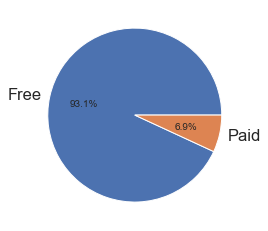

In [103]:
plt.pie(psdata1.Type.value_counts(), labels=['Free', 'Paid'], autopct='%1.1f%%')

# Insight: 93% of the Apps are Free in the Play Store.


In [104]:
psdata1['Price'] = pd.to_numeric(psdata1['Price'])
psdata1[psdata1.Price == psdata1.Price.max()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.3,10000,Paid,400.0,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up


# Insight : The most costly App in the Store is: I'm Rich - Trump Edition costing $400.


In [105]:
psdata1['Android Ver'].value_counts()

4.1 and up            2059
Varies with device    1319
4.0.3 and up          1240
4.0 and up            1129
4.4 and up             875
2.3 and up             580
5.0 and up             535
4.2 and up             337
2.3.3 and up           240
3.0 and up             211
2.2 and up             208
4.3 and up             207
2.1 and up             113
1.6 and up              87
6.0 and up              48
7.0 and up              41
3.2 and up              31
2.0 and up              27
5.1 and up              18
1.5 and up              15
3.1 and up               8
2.0.1 and up             7
4.4W and up              6
8.0 and up               5
7.1 and up               3
4.0.3 - 7.1.1            2
1.0 and up               2
5.0 - 8.0                2
4.1 - 7.1.1              1
5.0 - 6.0                1
7.0 - 7.1.1              1
Name: Android Ver, dtype: int64

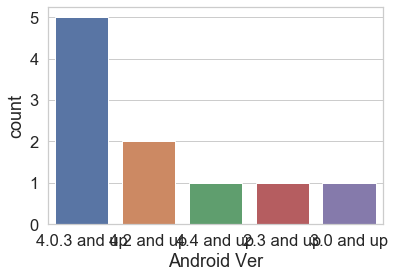

In [106]:
sns.countplot(psdata1['Android Ver'].iloc[:10])

# Insight : Most of the apps support Android 4.0 and above.


In [107]:
psdata1_full = psdata1[psdata1.Rating == 5]  
psdata1_full.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
329,Hojiboy Tojiboyev Life Hacks,COMICS,5.0,15,37,1000,Free,0.0,Everyone,Comics,"June 26, 2018",2.0,4.0.3 and up
612,American Girls Mobile Numbers,DATING,5.0,5,4.4,1000,Free,0.0,Mature 17+,Dating,"July 17, 2018",3.0,4.0.3 and up
615,Awake Dating,DATING,5.0,2,70,100,Free,0.0,Mature 17+,Dating,"July 24, 2018",2.2.9,4.4 and up
633,Spine- The dating app,DATING,5.0,5,9.3,500,Free,0.0,Teen,Dating,"July 14, 2018",4.0,4.0.3 and up
636,Girls Live Talk - Free Text and Video Chat,DATING,5.0,6,5.0,100,Free,0.0,Mature 17+,Dating,"August 1, 2018",8.2,4.0.3 and up


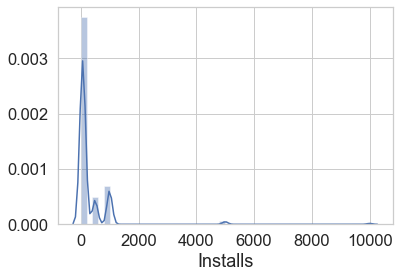

In [108]:
psdata1_full['Installs'] = pd.to_numeric(psdata1_full['Installs'])
sns.distplot(psdata1_full.Installs)

In [109]:
psdata1_full.Installs.value_counts().sort_index()

1          3
5          8
10        48
50        32
100      114
500       27
1000      38
5000       3
10000      1
Name: Installs, dtype: int64

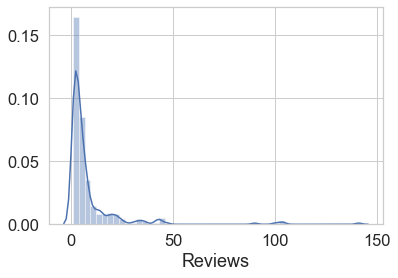

In [110]:
sns.distplot(psdata1_full.Reviews)

In [111]:
psdata1_full = psdata1_full[psdata1.Reviews > 10]

In [112]:
print("No. of Apps having 5.0 Rating with sufficient Reviews: ",psdata1_full.App.count())

No. of Apps having 5.0 Rating with sufficient Reviews:  50


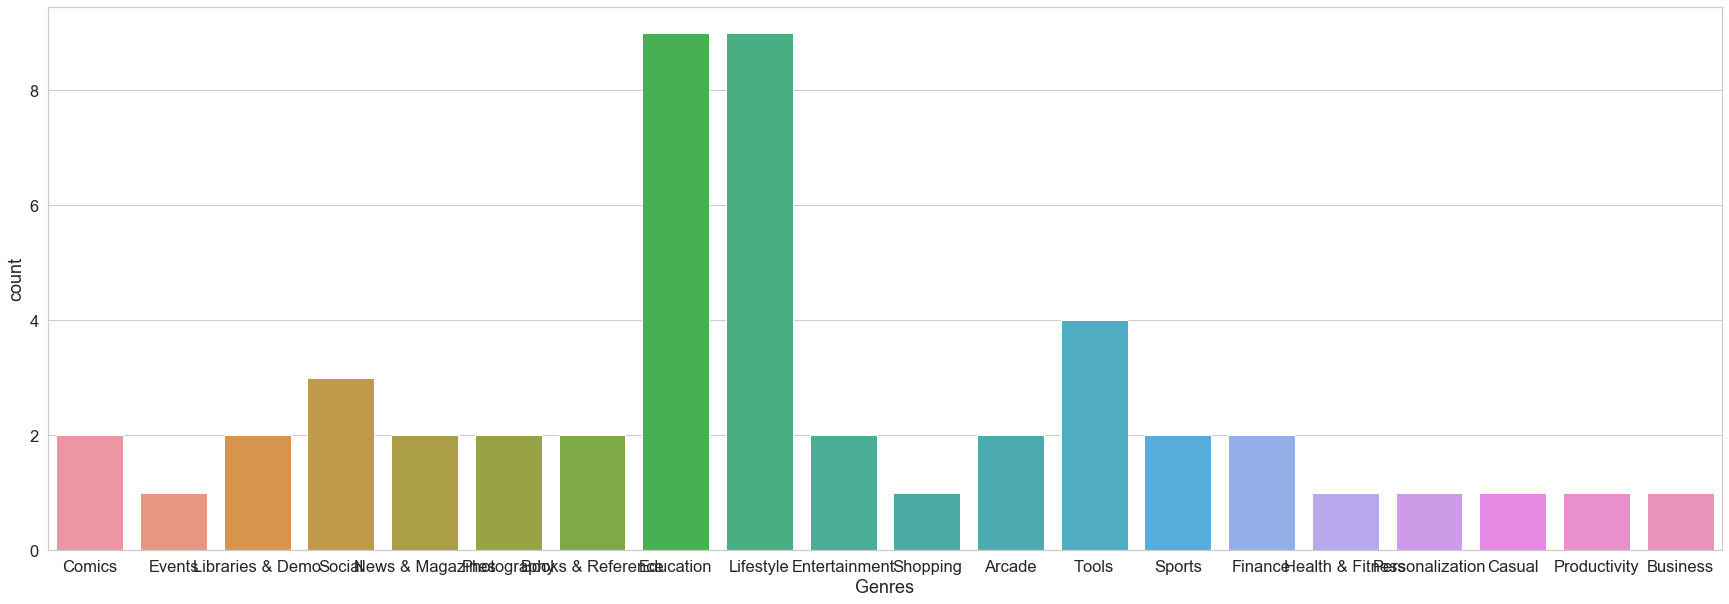

In [113]:
plt.figure(figsize=(30,10))
sns.countplot(psdata1_full.Genres)

# Apps related to Education, LifeStyle and Tools seem to fetch full Ratings with sufficient number of reviews.

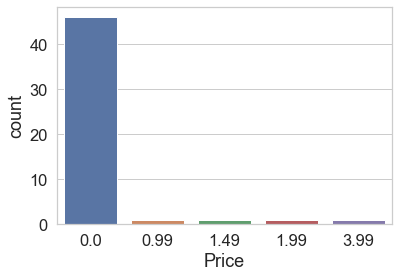

In [114]:
sns.countplot(psdata1_full.Price)

# Most of the apps are free to download.

In [115]:
psdata1.rename(columns={"Content Rating": "Content_Rating", 
                    'Current Ver': 'Current_Ver', 
                    'Android Ver':'Android_Ver', 'Last Updated':'Last_Updated'}, inplace=True)
psdata1.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [117]:
#Sort by "Category"
psdata1.sort_values("Category", inplace = True)

In [118]:
psdata1['Rating'].isnull().sum()

0

In [119]:
 psdata1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 3644
Data columns (total 13 columns):
App               9358 non-null object
Category          9358 non-null object
Rating            9358 non-null float64
Reviews           9358 non-null int64
Size              7721 non-null object
Installs          9358 non-null object
Type              9358 non-null object
Price             9358 non-null float64
Content_Rating    9358 non-null object
Genres            9358 non-null object
Last_Updated      9358 non-null object
Current_Ver       9358 non-null object
Android_Ver       9358 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 1023.5+ KB


In [120]:
psdata1["Rating"].describe()

count    9358.000000
mean        4.191814
std         0.515307
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

In [121]:
#layout = go.Layout(
 #   xaxis=dict(title='Ratings'),yaxis=dict(title='Number of Apps'))
#data = [go.Histogram(x=psdata1["Rating"])]
#fig = go.Figure(data=data, layout=layout)
#iplot(fig, filename='basic histogram')

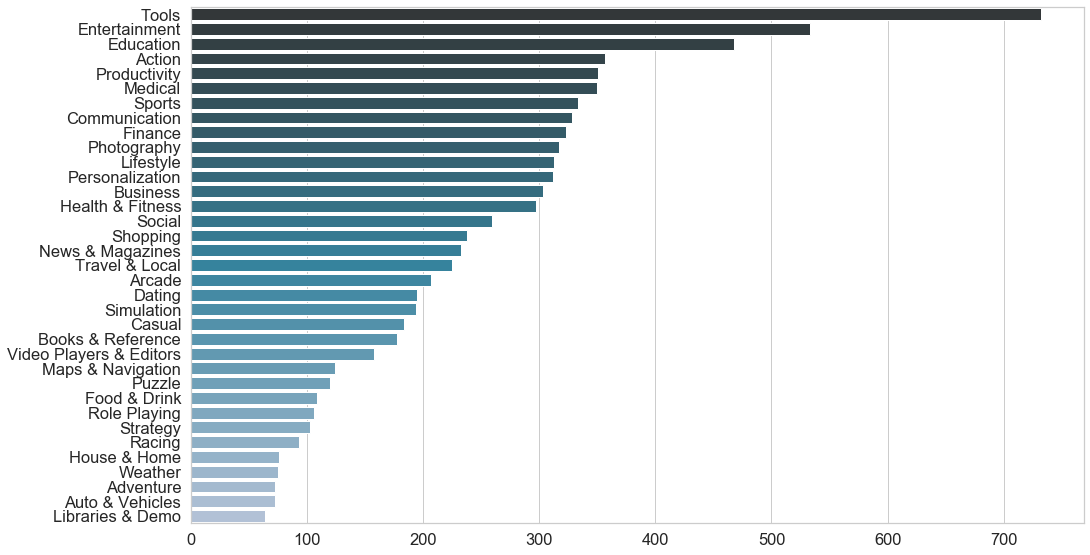

In [122]:
plt.figure(figsize=(16, 9.5))
genres = psdata1["Genres"].value_counts()[:35]
ax = sns.barplot(x=genres.values, y=genres.index, palette="PuBuGn_d")

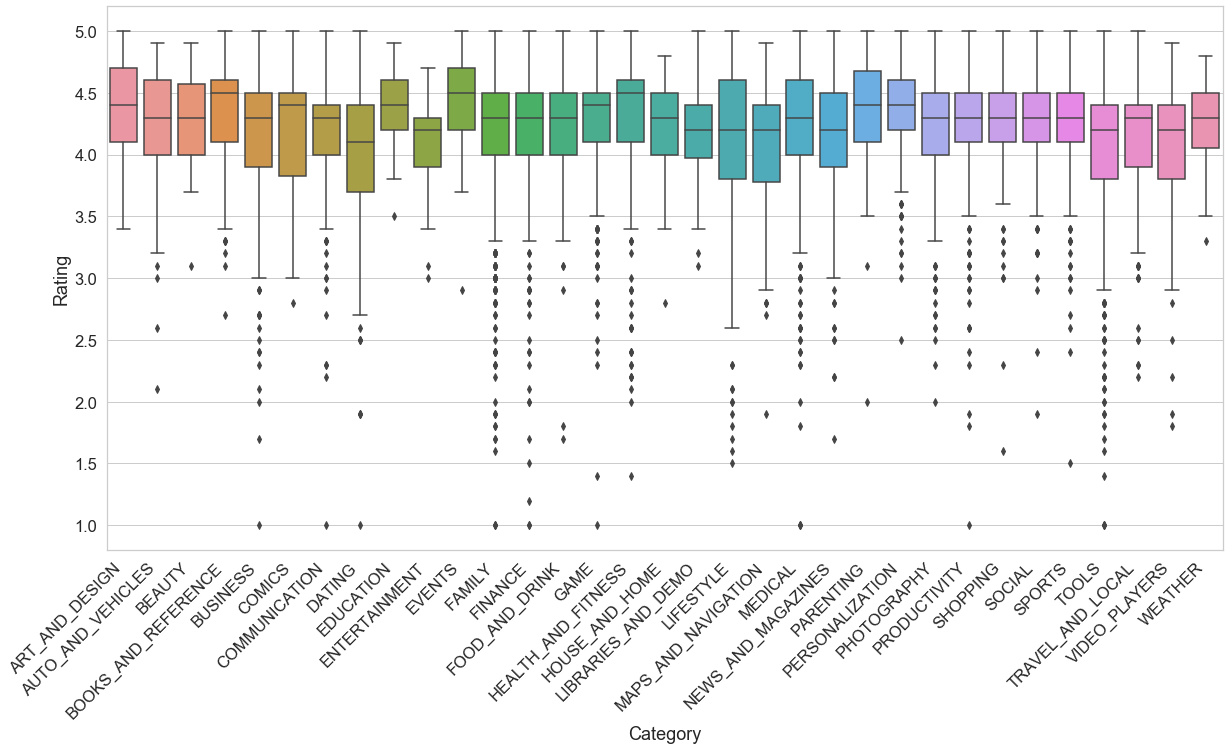

In [123]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5, style='whitegrid')
ax = sns.boxplot(x="Category",y="Rating",data=psdata1)
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,ha='right')

In [124]:
#Cut away rows which have < 4.0 ratings
highRating = psdata1.copy()
highRating = highRating.loc[highRating["Rating"] >= 4.0]
highRateNum = highRating.groupby('Category')['Rating'].nunique()
highRateNum

Category
ART_AND_DESIGN         10
AUTO_AND_VEHICLES       8
BEAUTY                 10
BOOKS_AND_REFERENCE    11
BUSINESS               11
COMICS                 10
COMMUNICATION          10
DATING                 11
EDUCATION              10
ENTERTAINMENT           8
EVENTS                 11
FAMILY                 11
FINANCE                11
FOOD_AND_DRINK         10
GAME                   11
HEALTH_AND_FITNESS     11
HOUSE_AND_HOME          9
LIBRARIES_AND_DEMO      9
LIFESTYLE              11
MAPS_AND_NAVIGATION    10
MEDICAL                11
NEWS_AND_MAGAZINES     11
PARENTING              11
PERSONALIZATION        11
PHOTOGRAPHY            11
PRODUCTIVITY           11
SHOPPING               10
SOCIAL                 11
SPORTS                 11
TOOLS                  11
TRAVEL_AND_LOCAL       10
VIDEO_PLAYERS          10
WEATHER                 9
Name: Rating, dtype: int64

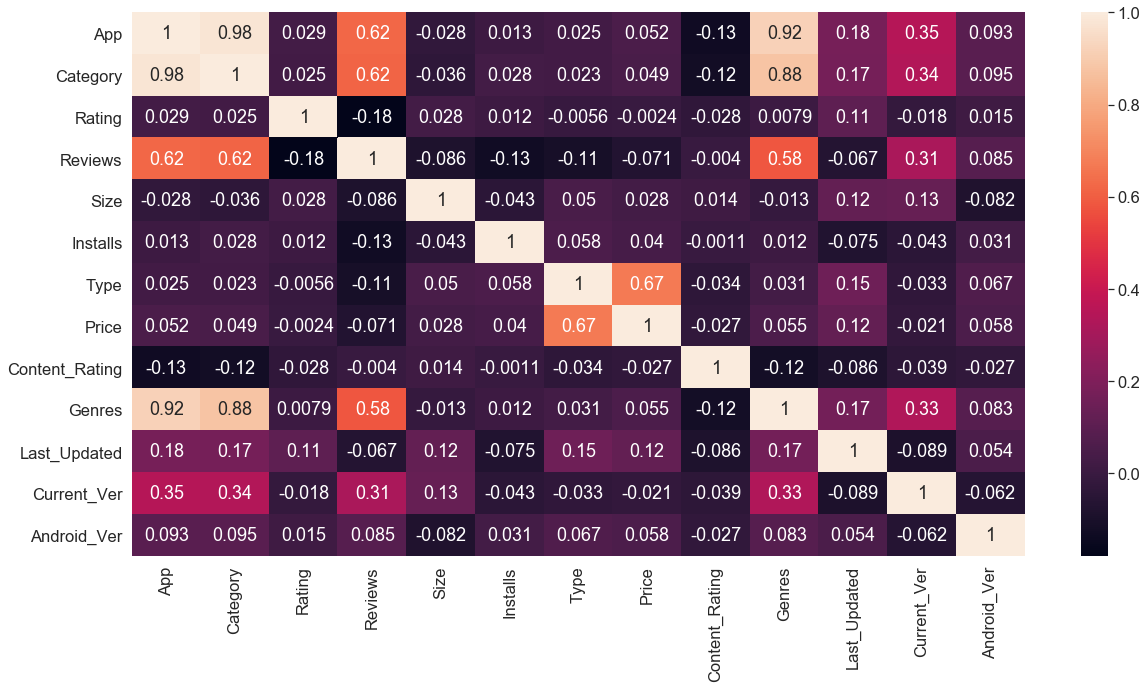

In [125]:
psdata1.dtypes
psdata1["Type"] = (psdata1["Type"] == "Paid").astype(int)
corr = psdata1.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True)

In [126]:
gpdata=pd.read_csv('googleplaystore.csv')  #RatingPrediction Using Multi-linear Regression,Decision Tree Regression & Light Gradient Boosted Model

In [127]:
gpdata.drop_duplicates(subset='App', inplace=True)
gpdata = gpdata.fillna(0) #Eliminating NA values and replacing with 0
y = len(gpdata)
print ('The number of unique App records in the data set is: ', y)

The number of unique App records in the data set is:  9660


In [128]:
#converting columns Size, Installs, Price into purely numeric columns

#Preparation for column Size
gpdata['Size'] = gpdata['Size'].apply(lambda a: str(a).replace('M', '') if 'M' in str(a) else a)
gpdata['Size'] = gpdata['Size'].apply(lambda a: str(a).replace(',', '') if '+' in str(a) else a)
gpdata['Size'] = gpdata['Size'].apply(lambda a: str(a).replace('+', '') if '+' in str(a) else a)
gpdata['Size'] = gpdata['Size'].apply(lambda a: float(str(a).replace('k', ''))/1000 if 'k' in str(a) else a)
gpdata['Size'] = gpdata['Size'].apply(lambda a: str(a).replace('Varies with device', 'NaN') if 'Varies with device' in str(a) else a)



#Preparation for column Installs
gpdata['Installs'] = gpdata['Installs'].apply(lambda a: str(a).replace('+', '') if '+' in str(a) else a)
gpdata['Installs'] = gpdata['Installs'].apply(lambda a: str(a).replace(',', '') if ',' in str(a) else a)
gpdata['Installs'] = gpdata['Installs'].apply(lambda a: str(a).replace('Free', 'NaN') if 'Free' in str(a) else a)


#Preparation for column Price
gpdata['Price'] = gpdata['Price'].apply(lambda a: str(a).replace('$', '') if '$' in str(a) else a)
gpdata['Price'] = gpdata['Price'].apply(lambda a: str(a).replace('Everyone', 'NaN') if 'Everyone' in str(a) else a)

#Preparation for column Reviews
gpdata = gpdata[~gpdata.Reviews.str.contains("3.0M")]

#Converting all the values of these columns to floats
gpdata['Size'] = gpdata['Size'].apply(lambda a : float(a))
gpdata['Installs'] = gpdata['Installs'].apply(lambda a : float(a))
gpdata['Price'] = gpdata['Price'].apply(lambda a : float(a))
gpdata['Reviews'] = gpdata['Reviews'].apply(lambda a: float(a))
gpdata['Rating'] = gpdata['Rating'].apply(lambda a: float(a))


In [129]:
gpdata.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


In [130]:
#After cleaning these columns and checking the length of the data once again:
z = len(gpdata)
print ('The number of unique App records in the data set is: ', z)

The number of unique App records in the data set is:  9659


In [131]:
#Data Visualisation:
no_of_distinct_categories =  len(set(gpdata['Category']))
print ('The dataset contains Apps belonging to', no_of_distinct_categories, 'Categories')

The dataset contains Apps belonging to 33 Categories


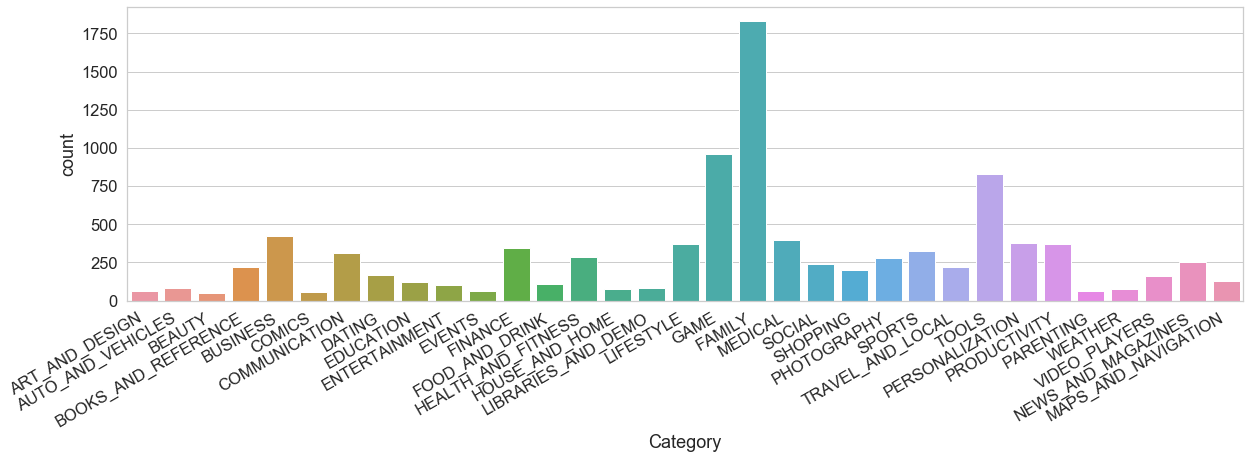

In [132]:
#Visualisation using matplotlib
#Number of categories of apps in the store
x = gpdata.Category
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
fig.autofmt_xdate()
no_of_cat_plot = sns.categorical.countplot(x)
plt.show()

In [133]:
#The results of the above visualisation can be better represented in a table

cat_table = gpdata.groupby('Category').size()
cat_table = cat_table.reset_index(name='Count').nlargest(10,'Count')
cat_table

,Category,Count
11,FAMILY,1832
14,GAME,959
29,TOOLS,827
4,BUSINESS,420
20,MEDICAL,395
23,PERSONALIZATION,376
25,PRODUCTIVITY,374
18,LIFESTYLE,369
12,FINANCE,345
28,SPORTS,325


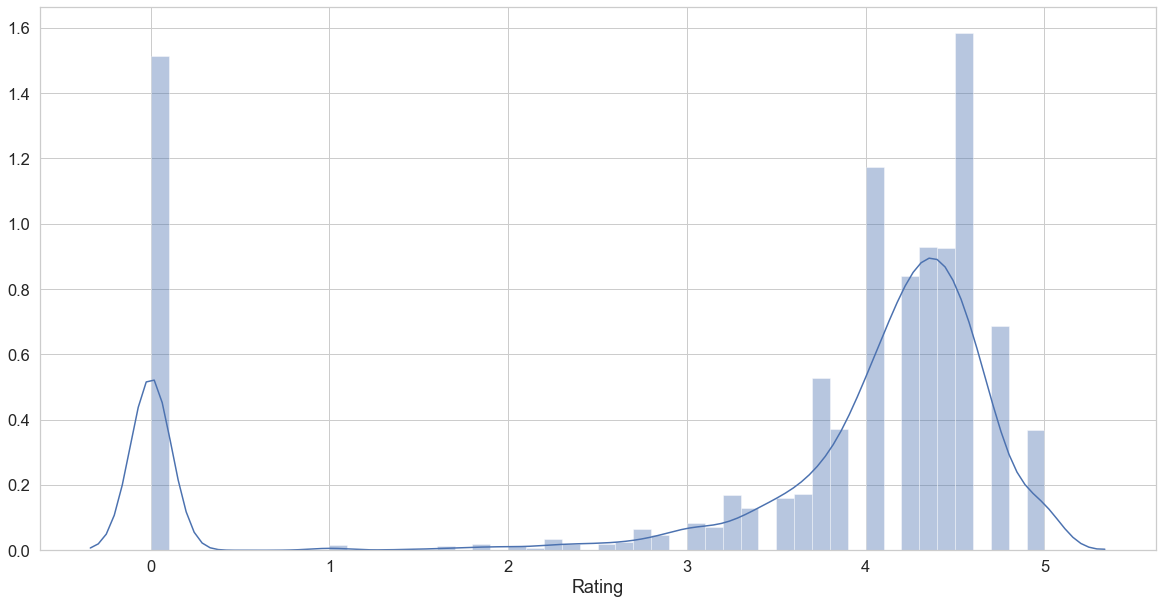

In [134]:
#Distribution of ratings for the dataset 
sns.distplot(gpdata['Rating'])

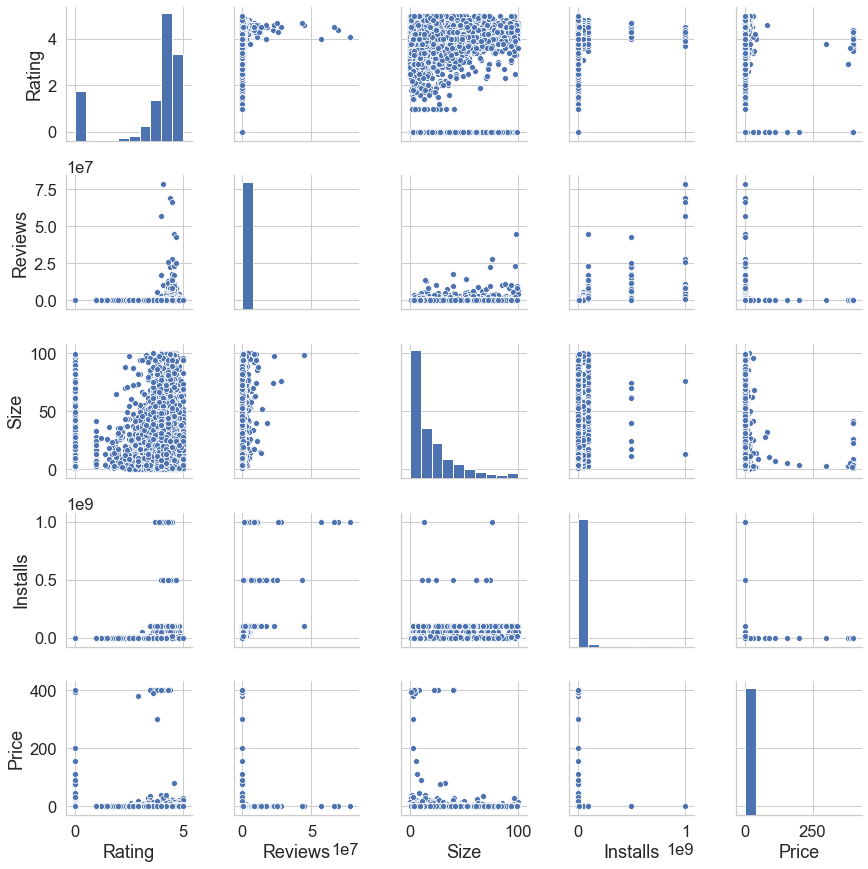

In [135]:
sns.pairplot(gpdata)

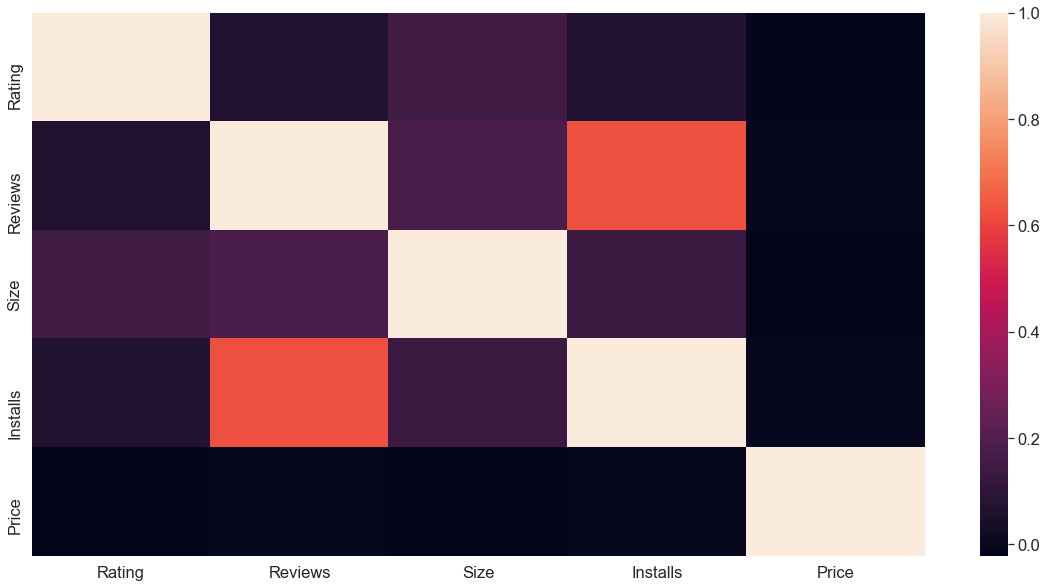

In [136]:
#Correlation Heatmap for numerical variables
sns.heatmap(gpdata.corr())

In [137]:
#Displaying the columns of the dataframe 
gpdata.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [138]:
# Function for preprocessing 
cat_columns = ['Category','Type','Content Rating', 'Android Ver']
num_columns = ['Reviews','Size','Price', 'Installs']
def preprocess(gpdata):
  preprocess_features = pd.DataFrame()
  for i in cat_columns:
    preprocess_features[i] = gpdata[i] 
    preprocess_features[i] = preprocess_features[i].astype('category')
  preprocess_features = pd.get_dummies(preprocess_features[cat_columns], drop_first = 'True')
  for i in num_columns:
    preprocess_features[i] = gpdata[i].astype('float')
  return preprocess_features

def preprocess_target(gpdata):
  output_targets = gpdata['Rating'].astype('float')
  return output_targets

In [139]:
#Data after preprocessing
gpdata =gpdata.fillna(0)
preproc_data = preprocess(gpdata)
target = preprocess_target(gpdata)

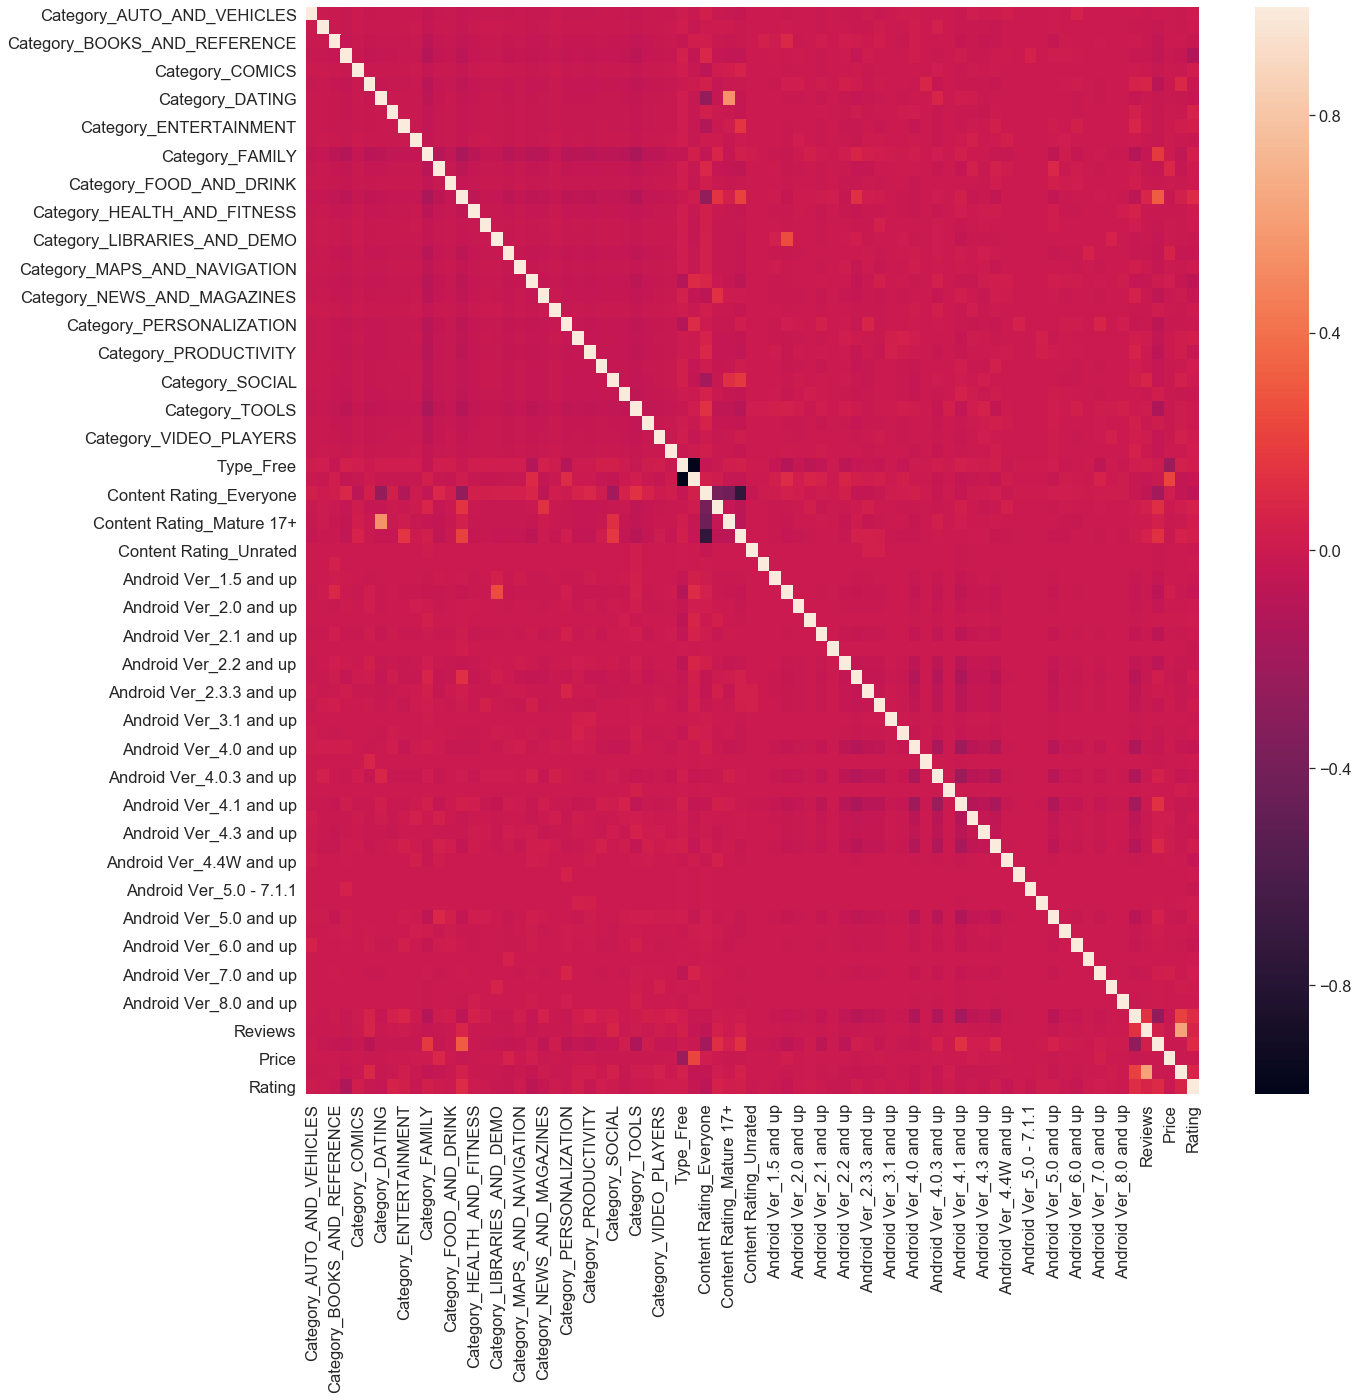

In [140]:
#Correlation for preproc_data
plt.figure(figsize = (20,20))
x = pd.concat([preproc_data, target], 1)
sns.heatmap(x.corr())

In [141]:
#Checking the shapes of the preprocessed data and the target variable 'Rating'
print(preproc_data.shape)
print(target.shape)

(9659, 76)
(9659,)


In [142]:
# Splitting the Dataset into training and testing sets
####X_train - Predictor Variables for training
####y_train - Target variable for training
####X_test - Known predictor Variables for testing
####y_test - Target variable for testing

from sklearn.model_selection import train_test_split as ts
X_train, X_test, y_train, y_test = ts(preproc_data, target, test_size=0.3, random_state=101)

# Decison Tree Model

In [143]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
#Fitting
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [144]:
#Saving Measurements of the model
from sklearn import metrics
pred1 = dt.predict(X_test)
mae_dt = metrics.mean_absolute_error(y_test,pred1)
mse_dt = metrics.mean_squared_error(y_test, pred1)
rmse_dt = np.sqrt(metrics.mean_squared_error(y_test, pred1))

print( mae_dt, mse_dt, rmse_dt)

0.770393374741201 2.2177846790890268 1.489222843999187


# light gbm : Gradient boosted method 

In [145]:
var = np.arange(1,50,5)
#Grid Search for getting parameters

from sklearn.model_selection import GridSearchCV
gridParams = {
'learning_rate' : [0.1, 0.12, 0.14,0.16,0.18, 0.2],
    'num_leaves' : [ 20,21,22,23,24,25,26,27]
}

#model for gridsearch

mdl = lgb.LGBMRegressor(metric = 'mae',
                       objective = 'regression',
                       n_estimators= 20000,
                       bagging_fraction = 0.7,
                       num_threads = 4,
                       colsample_bytree = 0.7,
                       num_boost_round = 100)

grid = GridSearchCV(mdl, gridParams, verbose =4, n_jobs = -1, scoring = 'neg_mean_absolute_error')

In [146]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   22.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.7, boosting_type='gbdt',
                                     class_weight=None, colsample_bytree=0.7,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='mae',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=20000, n_jobs=-1,
                                     num_boost_round=100, num_leaves...
                                     num_threads=4, objective='regression',
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
           

In [147]:
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.1, 'num_leaves': 22}
-0.6332938833647669


In [148]:
import lightgbm as lgb

param = {'learning_rate': 0.1, 'boosting_type': 'gbdt', 'num_leaves':25, 
         'nthread':4, 'num_trees':100, 'objective': 'regression', 
         'metric':'mse'}

In [149]:
train_data = lgb.Dataset(X_train, y_train, silent =False)
test_data = lgb.Dataset(X_test, y_test, silent = False)

lgbt = lgb.train(param, train_set = train_data, num_boost_round =100, verbose_eval =4)

In [150]:
pred2 = lgbt.predict(X_test, num_iteration = lgbt.best_iteration)

mae_lgb = metrics.mean_absolute_error(y_test,pred2)
mse_lgb = metrics.mean_squared_error(y_test, pred2)
rmse_lgb = np.sqrt(metrics.mean_squared_error(y_test, pred2))

print( mae_lgb, mse_lgb, rmse_lgb)

0.6231696962356382 1.0653789968613863 1.0321719802733391


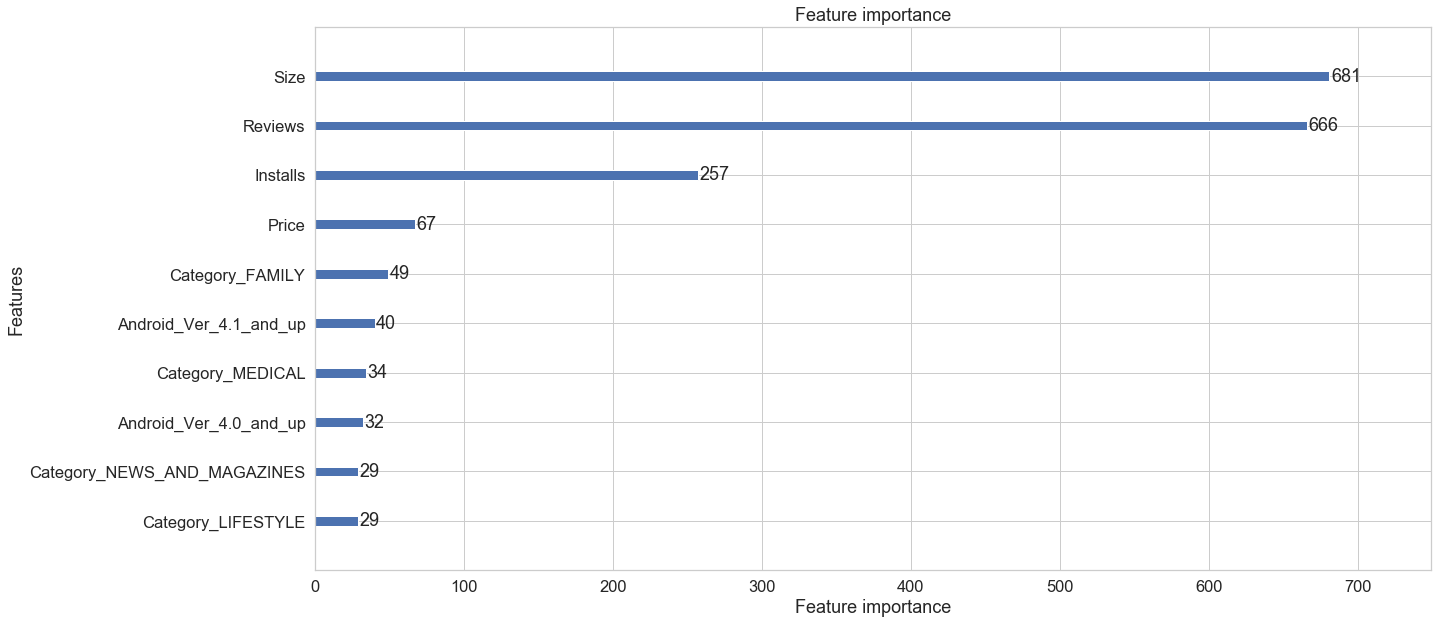

In [151]:
#visualizing important predictors
import matplotlib.pyplot as plt 

lgb.plot_importance(lgbt, max_num_features = 10)

# Linear Regression

In [152]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
pred3 = lr.predict(X_test)

mae_lr = metrics.mean_absolute_error(y_test,pred3)
mse_lr = metrics.mean_squared_error(y_test, pred3)
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, pred3))

print( mae_lr, mse_lr, rmse_lr)

1.1475782302838613 2.425740017323479 1.557478737358388


In [154]:
a = np.array([mae_lr,mse_lr,rmse_lr])
b = np.array([mae_dt,mse_dt,rmse_dt])
c = np.array([mae_lgb,mse_lgb,rmse_lgb])

x = pd.DataFrame(data =[a,b,c], columns = ['MAE','MSE','RMSE'], index = ['Multiple Linear Regression', 'Decision Tree Regression', 'Light Gradient Boosted Model'])
x

,MAE,MSE,RMSE
Multiple Linear Regression,1.147578,2.425740,1.557479
Decision Tree Regression,0.770393,2.217785,1.489223
Light Gradient Boosted Model,0.623170,1.065379,1.032172
